# Plan robust trajectory for spacecraft using randUP

In [21]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.spatial import ConvexHull
import time

from models.spacecraft import Model, SpacecraftProblem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define Problem

In [22]:
s13     = np.sqrt(1./3.)
x_init  = np.array([1,0.2,0.0,  1e-4,1e-4,1e-4,  -0.5,0.5,-0.5,0.5,  0,0,0])
x_goal  = np.array([1.2,4.8,2.0,  1e-4,1e-4,1e-4,  s13,0.,s13,s13,     0,0,0])
N       = 21

problem = SpacecraftProblem(x0=x_init, xgoal=x_goal, N=N)

Initializing problem with 2 spherical obstacles.
[SpacecraftProblem::__init__] 2 sphere obs, and 0 poly obs.


### Add obstacles

In [23]:
problem.sphere_obstacles[0] = [[1.25, 1.5, 0.0], 0.4]
problem.sphere_obstacles[1] = [[1., 3.50, 0.0], 0.4]
problem.sphere_obstacles.append([[0,3.25,0.],0.4])

### Load model

In [24]:
model = Model()
model

[spacecraft::__init__] Initializing spacecraft Model 
                       (linear, uncertain mass and inertia).
[spacecraft::reset] resetting mass, J, and deltas.


### Define controller

In [25]:
from ccscp.ccscp_controller import CCSCPController
controller = CCSCPController(model=model, problem=problem)

[CCSCPModel::__init__] Initializing model, using  <models.spacecraft.Model object at 0x7f66c0c9e860>
[ccscp_model::initialize_traj] using straight-line initialization.
OSQP Problem size:  P = (413, 413) q = (413,) A = (2448, 413) l = (2448,) u = (2448,)
[spacecraft::reset] resetting mass, J, and deltas.


In [26]:
print(controller.model.UP_config['N_MC'])
print(controller.UP_config['N_MC'])
print(controller.UP_config['B_feedback'])
print(controller.model.UP_config['B_feedback'])

100
100
False
False


### Plan!

In [27]:
from time import time

In [28]:
start = time()
Xtraj, Utraj, UP_vals, UP_config = controller.plan(N=N, init_method='straightline')
print('elapsed_time=',time()-start)

start = time()
Xtraj_2, Utraj_2, UP_vals_2, UP_config_2 = controller.plan(N=N, init_method='left')
print('elapsed_time=',time()-start)

[ccscp_model::initialize_traj] using straight-line initialization.
Convergence Metric: 20.93%
[solve_ccscp] Success: True, Nb of iterations: 3
elapsed_time= 0.8209347724914551
[ccscp_model::initialize_traj] using left initialization.
[solve_ccscp] Failure to solve SCP iter #1
elapsed_time= 0.6907620429992676


../../ccscp/src/ccscp/cc_ocp.py:499: UserWarning: [solve_OSQP]: Problem unfeasible.
  warn("[solve_OSQP]: Problem unfeasible.")


### Plot results

(0, 5.5)

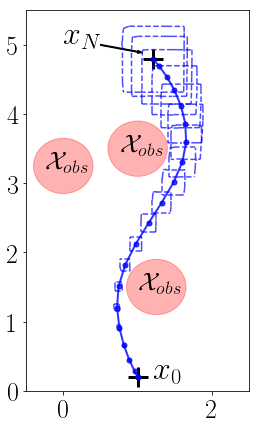

In [29]:
from utils.spacecraft_plot import *
idx=[0,1]
from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(4, 7))

# plot trajectory
for t in range(1,N):
    hull = ConvexHull(UP_vals['parts'][:,idx,t])
    for simplex in hull.simplices:
        plt.plot(UP_vals['parts'][simplex,idx[0],t], UP_vals['parts'][simplex,idx[1],t], 'b--', alpha=0.7)
plt.plot(Xtraj[0,:], Xtraj[1,:], 'b-o', alpha=0.8, markersize=5, linewidth=2)
        
for obs in problem.sphere_obstacles:
    pos, radius = obs[0], obs[1]
    ax = plot_circle(ax, pos, radius, color='r', alpha=0.3)
    plt.text(pos[idx[0]]-0.23, pos[idx[1]]-0.1, r'$\mathcal{X}_{obs}$', fontsize=26)


rc('text', usetex=True)

plt.scatter(x_init[idx[0]], x_init[idx[1]], s=400, color='black', marker='+', linewidth=3)
plt.scatter(x_goal[idx[0]], x_goal[idx[1]], s=400, color='black', marker='+', linewidth=3)

plt.text( x_init[idx[0]]+0.2, x_init[idx[1]]-0.1, r'$x_{0}$', fontsize=32,   weight="bold")
plt.text( x_goal[idx[0]]-1.2, x_goal[idx[1]]+0.15, r'${x}_{N}$', fontsize=32, weight="bold")
plt.arrow(x_goal[idx[0]]-0.7, x_goal[idx[1]]+0.2, 0.5, -0.1, 
          color='black', width=0.015)

ax.tick_params("both", labelsize=26) 
plt.xlim([-0.5,2.5])
plt.ylim([0,5.5])

(0, 5.5)

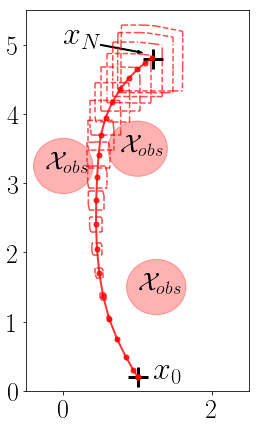

In [30]:
from utils.spacecraft_plot import *
idx=[0,1]
from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(4, 7))

# plot trajectory
for t in range(1,N):
    for simplex in ConvexHull(UP_vals_2['parts'][:,idx,t]).simplices:
        plt.plot(UP_vals_2['parts'][simplex,idx[0],t], 
                 UP_vals_2['parts'][simplex,idx[1],t], 'r--', alpha=0.7)
plt.plot(Xtraj_2[idx[0],:], Xtraj_2[idx[1],:], 'r-o', alpha=0.8, markersize=5, linewidth=2)
        
for obs in problem.sphere_obstacles:
    pos, radius = obs[0], obs[1]
    ax = plot_circle(ax, pos, radius, color='r', alpha=0.3)
    plt.text(pos[idx[0]]-0.23, pos[idx[1]]-0.1, r'$\mathcal{X}_{obs}$', fontsize=26)

rc('text', usetex=True)

plt.scatter(x_init[idx[0]], x_init[idx[1]], s=400, color='black', marker='+', linewidth=3)
plt.scatter(x_goal[idx[0]], x_goal[idx[1]], s=400, color='black', marker='+', linewidth=3)

plt.text( x_init[idx[0]]+0.2, x_init[idx[1]]-0.1, r'$x_{0}$', fontsize=32,   weight="bold")
plt.text( x_goal[idx[0]]-1.2, x_goal[idx[1]]+0.15, r'${x}_{N}$', fontsize=32, weight="bold")
plt.arrow(x_goal[idx[0]]-0.7, x_goal[idx[1]]+0.2, 0.5, -0.1, 
          color='black', width=0.015)

ax.tick_params("both", labelsize=26) 
plt.xlim([-0.5,2.5])
plt.ylim([0,5.5])

(-0.25, 5.75)

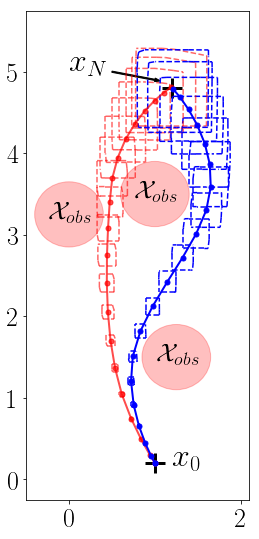

In [31]:
from utils.spacecraft_plot import *
idx=[0,1]
from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(4, 9))

# plot trajectory
for t in range(1,N):
    for simplex in ConvexHull(UP_vals_2['parts'][:,idx,t]).simplices:
        plt.plot(UP_vals_2['parts'][simplex,idx[0],t], 
                 UP_vals_2['parts'][simplex,idx[1],t], 'r--', alpha=0.6)
    for simplex in ConvexHull(UP_vals['parts'][:,idx,t]).simplices:
        plt.plot(UP_vals['parts'][simplex,idx[0],t], 
                 UP_vals['parts'][simplex,idx[1],t], 'b--', alpha=1)
plt.plot(Xtraj_2[idx[0],:], Xtraj_2[idx[1],:], 'r-o', alpha=0.7, markersize=5, linewidth=2)
plt.plot(Xtraj[idx[0],:], Xtraj[idx[1],:],     'b-o', alpha=1, markersize=5, linewidth=2)
        
for obs in problem.sphere_obstacles:
    pos, radius = obs[0], obs[1]
    ax = plot_circle(ax, pos, radius, color='r', alpha=0.25)
    plt.text(pos[idx[0]]-0.23, pos[idx[1]]-0.1, r'$\mathcal{X}_{obs}$', fontsize=26)

rc('text', usetex=True)

plt.scatter(x_init[idx[0]], x_init[idx[1]], s=400, color='black', marker='+', linewidth=3)
plt.scatter(x_goal[idx[0]], x_goal[idx[1]], s=400, color='black', marker='+', linewidth=3)

plt.text( x_init[idx[0]]+0.2, x_init[idx[1]]-0.1, r'$x_{0}$', fontsize=32,   weight="bold")
plt.text( x_goal[idx[0]]-1.2, x_goal[idx[1]]+0.15, r'${x}_{N}$', fontsize=32, weight="bold")
plt.arrow(x_goal[idx[0]]-0.7, x_goal[idx[1]]+0.2, 0.5, -0.1, 
          color='black', width=0.015)

ax.tick_params("both", labelsize=26) 
plt.xlim([-0.5,2.1])
plt.ylim([-0.25,5.75])

In [32]:
problem.sphere_obstacles[0]

[[1.25, 1.5, 0.0], 0.4]

### positions

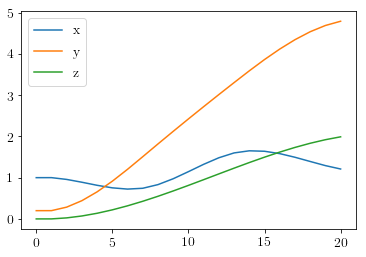

In [33]:
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[0,:], label='x')
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[1,:], label='y')
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[2,:], label='z')
plt.legend()

### quaternions

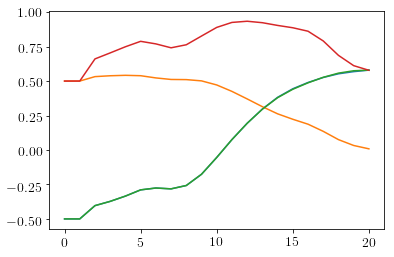

In [34]:
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[6,:])
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[7,:])
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[8,:])
plt.plot(np.arange(len(Xtraj[0,:])), Xtraj[9,:])

### controls

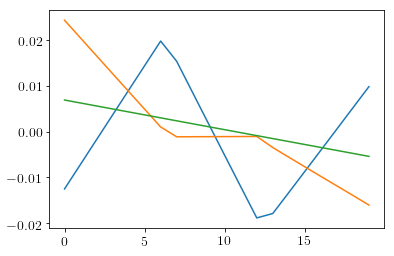

In [35]:
plt.plot(np.arange(len(Utraj[0,:])), Utraj[0,:])
plt.plot(np.arange(len(Utraj[0,:])), Utraj[1,:])
plt.plot(np.arange(len(Utraj[0,:])), Utraj[2,:])

## Parameters sensitivity analysis

In [36]:
vec_t_close = np.array([8, 14])
vec_j_close = []

In [37]:
for t_close in vec_t_close:
    t = t_close
    if t_close < 10:
        obs_close = problem.sphere_obstacles[0]
    else:
        obs_close = problem.sphere_obstacles[1]
    pos_obs = obs_close[0][:2]
    # replicate to compute distances
    N_MC    = UP_vals['parts'].shape[0]
    pos_obs = np.repeat(np.array([pos_obs]), N_MC, axis=0)
    # compute distances
    pos_t_randUP = UP_vals['parts'][:,idx,t]
    dists_to_obs = np.linalg.norm(pos_t_randUP-pos_obs, axis=1)
    j_closest    = np.argmin(dists_to_obs)
    vec_j_close.append(j_closest)
    # 
    print('t close = ', t_close)
    print('mass closest = ', model.masses_MC[j_closest])
    print('J00  closest = ', model.Js_MC[j_closest,0,0])
    print('J11  closest = ', model.Js_MC[j_closest,1,1])
    print('J22  closest = ', model.Js_MC[j_closest,2,2])
    print('w_2  closest = ', 1e3 * model.ws_MC[j_closest,0,:3],  '   (pos)')
    print('w_2  closest = ', 1e3 * model.ws_MC[j_closest,0,3:6], '   (vel)')

t close =  8
mass closest =  7.3
J00  closest =  0.065
J11  closest =  0.065
J22  closest =  0.07500000000000001
w_2  closest =  [ 0.079 -0.079  0.079]    (pos)
w_2  closest =  [ 0.433 -0.433 -0.433]    (vel)
t close =  14
mass closest =  7.1000000000000005
J00  closest =  0.065
J11  closest =  0.07500000000000001
J22  closest =  0.07500000000000001
w_2  closest =  [ 0.079 -0.079  0.079]    (pos)
w_2  closest =  [ 0.433  0.433 -0.433]    (vel)


In [38]:
model.ws_MC[j_closest,6,3:6] * 1e3

array([ 0.433,  0.433, -0.433])

In [39]:
vec_j_close

[24, 82]

(1.0, 4.25)

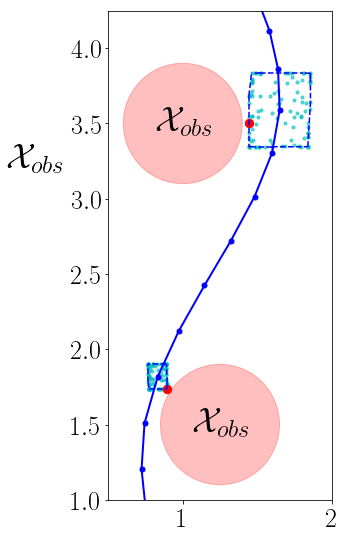

In [40]:
from utils.spacecraft_plot import *
from utils.viz import plot_pts_2d, plot_trajs_2d

idx=[0,1]
from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(4, 9))

# plot trajectory
for t in range(1,N):
    if t in vec_t_close:
        j_closest = vec_j_close[np.argwhere(vec_t_close==t)[0,0]]
        plot_pts_2d(UP_vals['parts'][:,idx,t], idx=idx, color='c', alpha=0.6, markerwidth=10)
        for simplex in ConvexHull(UP_vals['parts'][:,idx,t]).simplices:
            plt.plot(UP_vals['parts'][simplex,idx[0],t], 
                     UP_vals['parts'][simplex,idx[1],t], 'b--', alpha=1)
        plt.scatter(UP_vals['parts'][j_closest,idx[0],t], UP_vals['parts'][j_closest,idx[1],t], color='r', s=70)
plt.plot(Xtraj[idx[0],:], Xtraj[idx[1],:], 'b-o', alpha=1, markersize=5, linewidth=2)
        
for obs in problem.sphere_obstacles:
    pos, radius = obs[0], obs[1]
    ax = plot_circle(ax, pos, radius, color='r', alpha=0.25)
    plt.text(pos[idx[0]]-0.18, pos[idx[1]]-0.08, r'$\mathcal{X}_{obs}$', fontsize=35)


rc('text', usetex=True)

plt.scatter(x_init[idx[0]], x_init[idx[1]], s=400, color='black', marker='+', linewidth=3)
plt.scatter(x_goal[idx[0]], x_goal[idx[1]], s=400, color='black', marker='+', linewidth=3)

ax.tick_params("both", labelsize=26) 
plt.xlim([0.5,2.])
plt.ylim([1.,4.25])